In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random

%matplotlib inline

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance)

In [282]:
df=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [290]:
meth=[]
ndat=[]
for i in np.unique(df.Method)[:-3]: # de-slice this
    df2=df[df.Method==i]
    df1=df[df.Method=='Tully-Fisher'] # de-tab this
    meth+=[i]
    ndat+=[df2.shape[0]]
info=pd.DataFrame({'method':meth,'nrows':ndat})

In [355]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=1
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe
disterr=0.461*dfs['D (Mpc)']*dfs.err 
len(ulist)

8792

In [356]:
%%time
nbins=10000 # 
names=[]
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
dboot=[] #6
wstd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
#    names+=[i] # esto no se necesita
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    wstd+=[weighted_std(dummy['D (Mpc)'],dumerr)]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)] # mean bootstrap error
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))] # the error of the error
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
    dboot+=[np.mean(bootmean)/1e6] # bootstrap mean D

CPU times: user 2min 58s, sys: 0 ns, total: 2min 58s
Wall time: 2min 59s


In [376]:
def lnlikelin(theta, x, y,yerr):# modelo por cuadratura, no pasa PP check
    m ,b = theta
    model = m * x**2 + b**2
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b = theta
    if 0 < m < 10 and 0 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

def discrepq(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))
        
def discrepq2(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
            yexp=np.sqrt(yexp)
            ysim=np.sqrt(ysim)
            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

In [ ]:
# Y este modelo como pa' que?
# modelo por cuadratura con w=yerr**-1 no funciona con FT p-value
# modelo por cuadratura con w=yerr**-2 no funciona con FT p-value (aun menos)
# modelo por cuadratura con w=yerr**-1 no funciona con FT p-value usando directamente y
# modelo por cuadratura con w=yerr**-2 no funciona con FT p-value usando directamente y (aun menos)

1 [ 0.08177229  0.26353757] 8792 837.038654193
Rejection rate = 100 %
2 [ 0.10086809  0.26376468] 7206 837.038654193
Rejection rate = 100 %
3 [ 0.12185908  0.19736986] 5234 837.038654193
Rejection rate = 100 %
4 [ 0.12912342  0.16026281] 3843 837.038654193
Rejection rate = 100 %
5 [ 0.1275923   0.16227569] 3201 185.046755778
Rejection rate = 100 %
6 [ 0.1294664   0.14798133] 2742 174.444324283
Rejection rate = 100 %
7 [ 0.13117321  0.14815377] 2299 169.931786108
Rejection rate = 100 %
8 [ 0.13187017  0.13495028] 1827 169.931786108
Rejection rate = 100 %
9 [ 0.13217861  0.13647739] 1489 143.188488944
Rejection rate = 100 %
10 [ 0.1315867   0.13280771] 1263 143.188488944
Rejection rate = 100 %
11 [ 0.12483849  1.70375826] 1061 143.188488944
Rejection rate = 99 %
Bayesian p-value: 0.0
12 [ 0.12057113  1.98913581] 826 143.188488944
Rejection rate = 99 %
Bayesian p-value: 0.0
13 [ 0.11570399  2.34740868] 602 143.188488944
Rejection rate = 95 %
Bayesian p-value: 0.0
14 [ 0.11818783  2.917399

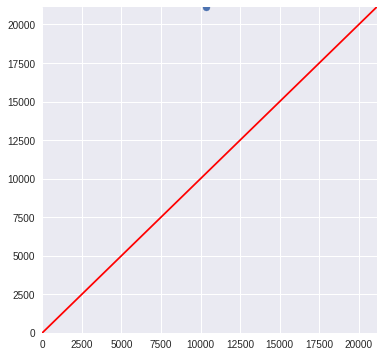

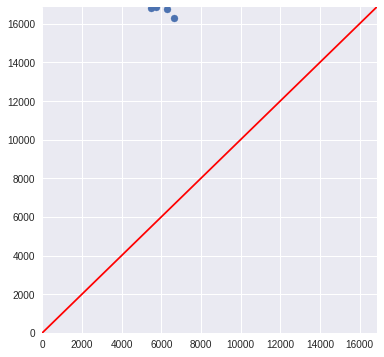

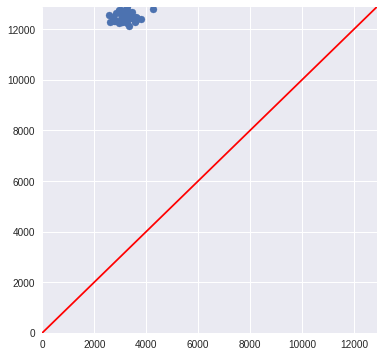

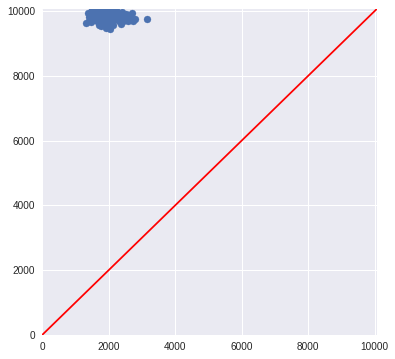

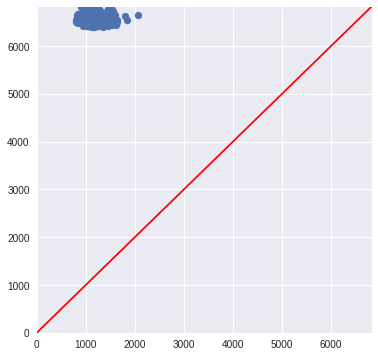

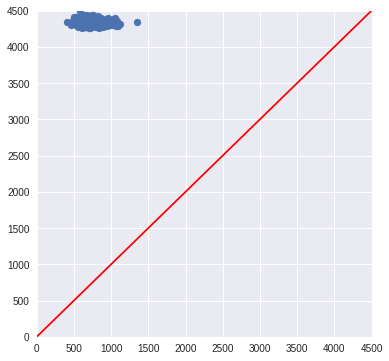

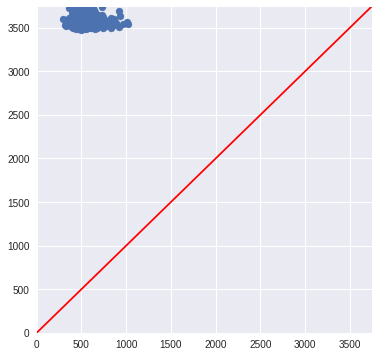

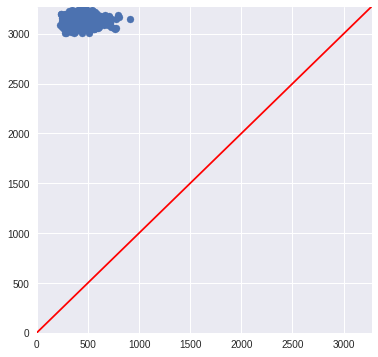

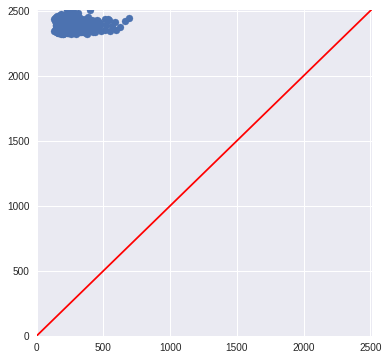

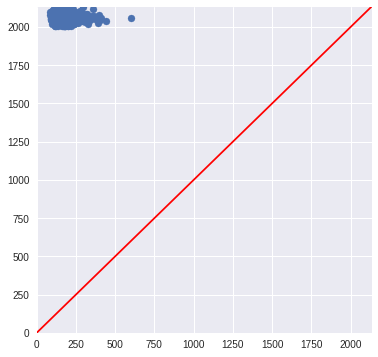

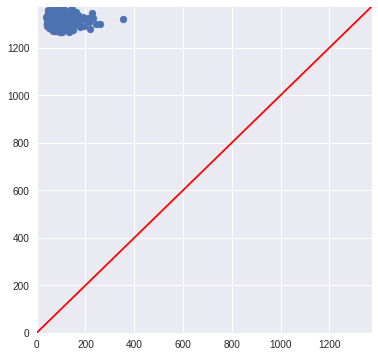

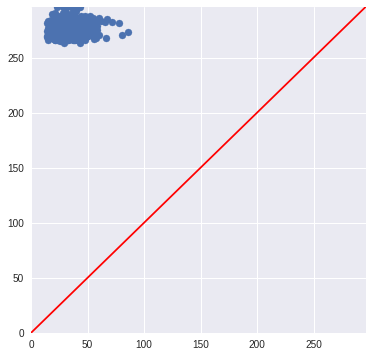

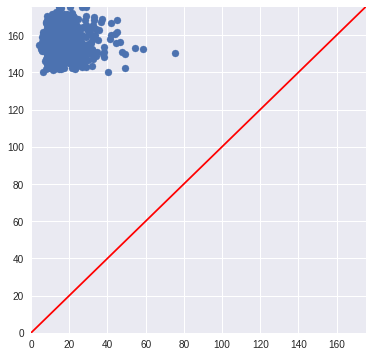

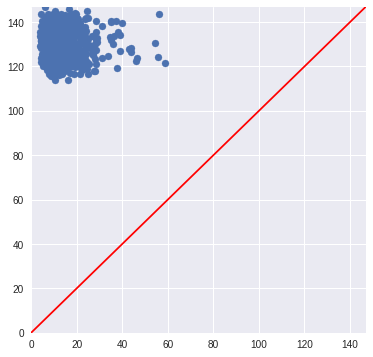

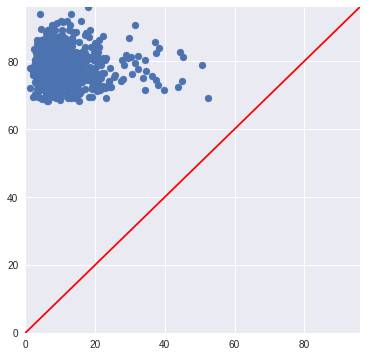

In [374]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(1,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    result = (1,4)
    m_ml, b_ml = result
#    if b_ml > 0:
    ndim, nwalkers = len(result), 100
    pos = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0),filt.sum(),x.max())
    coun+=1
    discrepq(samples,x,y,yerr)

1 [ 0.08178792  0.25867817] 8792 837.038654193
Rejection rate = 100 %
2 [ 0.10086335  0.26130766] 7206 837.038654193
Rejection rate = 100 %
3 [ 0.12184469  0.19176497] 5234 837.038654193
Rejection rate = 100 %
4 [ 0.12908163  0.15559771] 3843 837.038654193
Rejection rate = 100 %
5 [ 0.1276663   0.16255627] 3201 185.046755778
Rejection rate = 100 %
6 [ 0.12953682  0.14794907] 2742 174.444324283
Rejection rate = 100 %
7 [ 0.13120352  0.14239694] 2299 169.931786108
Rejection rate = 100 %
8 [ 0.13193068  0.13442817] 1827 169.931786108
Rejection rate = 100 %
9 [ 0.13208565  0.13060815] 1489 143.188488944
Rejection rate = 100 %
10 [ 0.13154495  0.13060121] 1263 143.188488944
Rejection rate = 100 %
11 [ 0.12490116  1.70160008] 1061 143.188488944
Rejection rate = 99 %
Bayesian p-value: 0.0
12 [ 0.12053229  1.99367954] 826 143.188488944
Rejection rate = 99 %
Bayesian p-value: 0.0
13 [ 0.11567324  2.35016154] 602 143.188488944
Rejection rate = 95 %
Bayesian p-value: 0.0
14 [ 0.11820935  2.916332

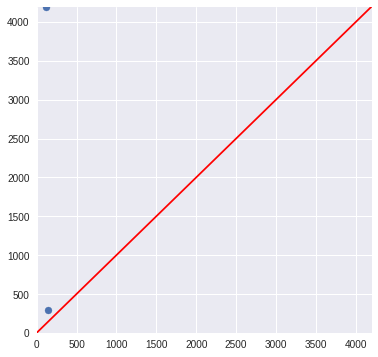

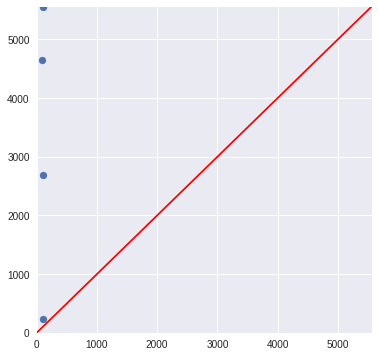

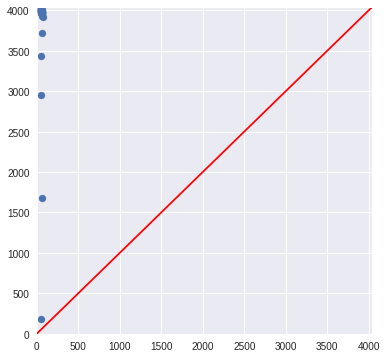

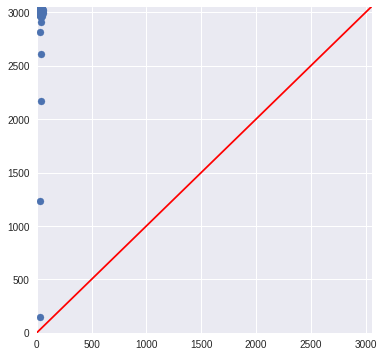

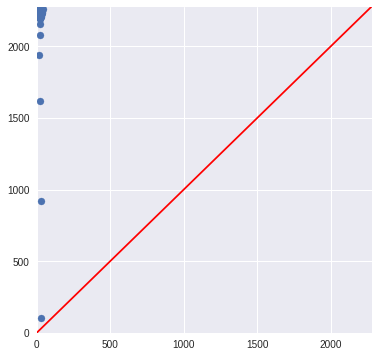

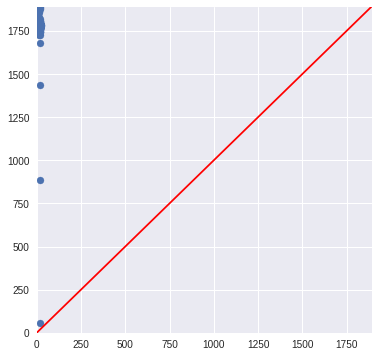

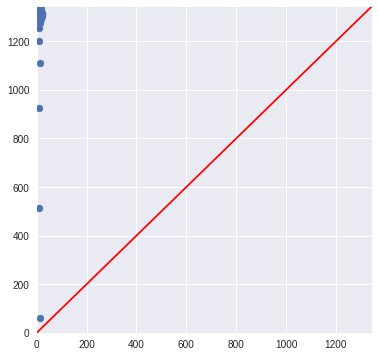

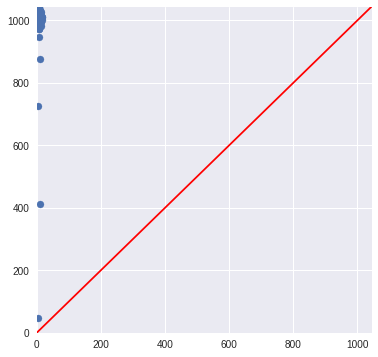

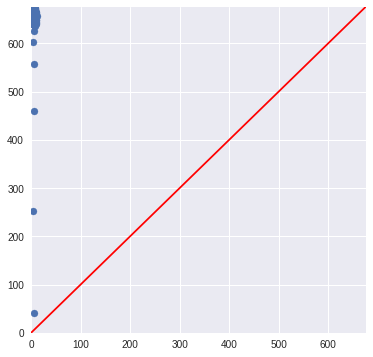

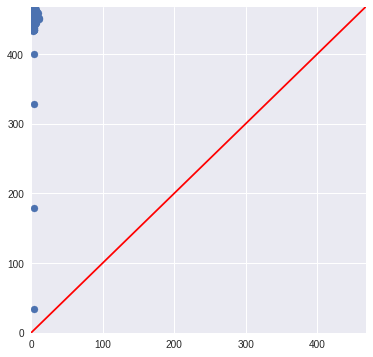

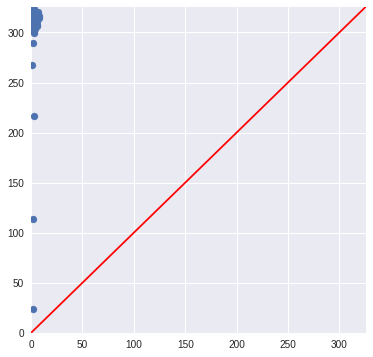

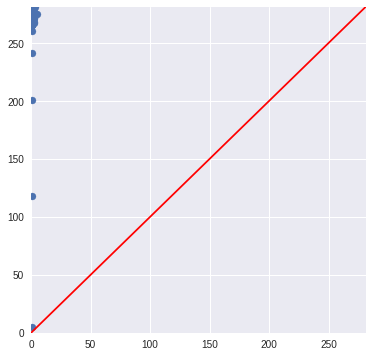

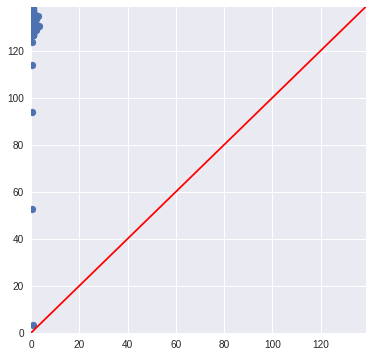

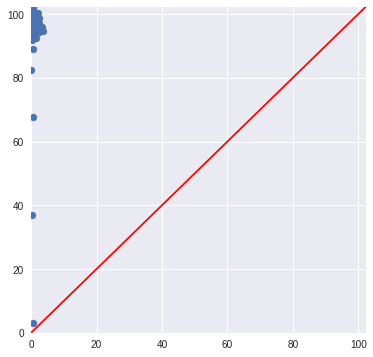

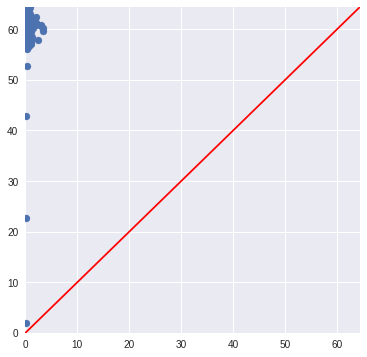

In [377]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(1,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    result = (1,4)
    m_ml, b_ml = result
#    if b_ml > 0:
    ndim, nwalkers = len(result), 100
    pos = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0),filt.sum(),x.max())
    coun+=1
    discrepq2(samples,x,y,yerr)

1 [ 0.13014661  0.02249417] 8792 837.038654193
Rejection rate = 98 %
Bayesian p-value: 0.0
2 [ 0.15043282  0.02330042] 7206 837.038654193
Rejection rate = 85 %
Bayesian p-value: 0.0
3 [ 0.27755731  0.01909256] 5234 837.038654193
Rejection rate = 36 %
Bayesian p-value: 0.0
4 [ 0.37922334  0.01066219] 3843 837.038654193
Rejection rate = 14 %
Bayesian p-value: 0.0
5 [ 0.11723756  3.70622824] 3201 185.046755778
Rejection rate = 0 %
Bayesian p-value: 0.0
6 [ 0.12090294  3.60805821] 2742 174.444324283
Rejection rate = 0 %
Bayesian p-value: 0.0
7 [ 0.12520527  3.479122  ] 2299 169.931786108
Rejection rate = 0 %
Bayesian p-value: 0.0
8 [ 0.12647446  3.43288062] 1827 169.931786108
Rejection rate = 0 %
Bayesian p-value: 0.0
9 [ 0.12894976  3.24267   ] 1489 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
10 [ 0.12917684  3.17459488] 1263 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
11 [ 0.12302885  4.99338345] 1061 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
12 [

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 [ 0.19156265  4.26534566] 53 65.6827536324
Rejection rate = 0 %
Bayesian p-value: 0.0
23 [ 0.28089544  0.16434704] 31 31.6677431289
Rejection rate = 0 %
Bayesian p-value: 0.0
24 [ 0.28739079  0.20305322] 22 31.6677431289
Rejection rate = 0 %
Bayesian p-value: 0.0
25 [ 0.2185522   3.52904739] 15 28.9241085243
Rejection rate = 0 %
Bayesian p-value: 0.0


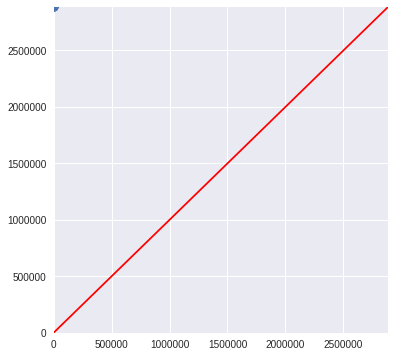

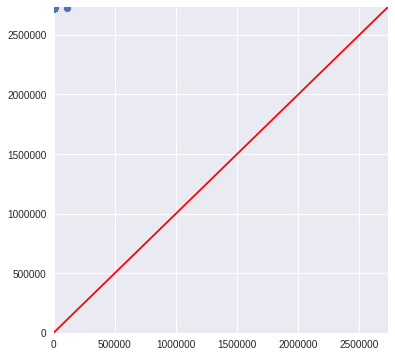

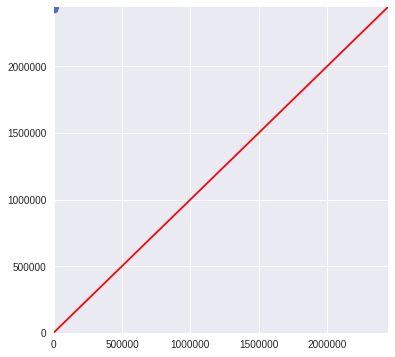

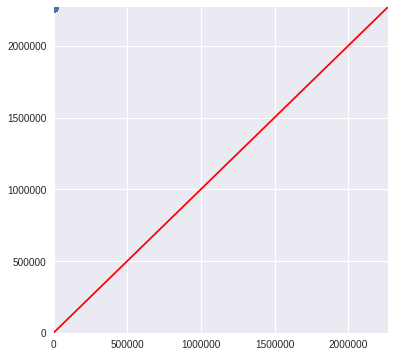

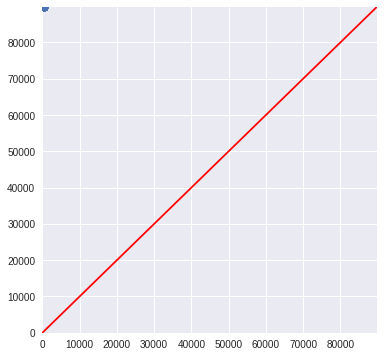

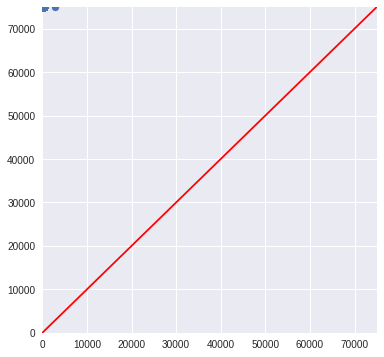

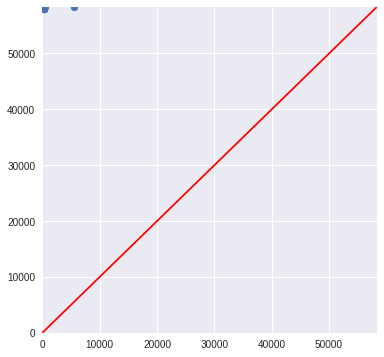

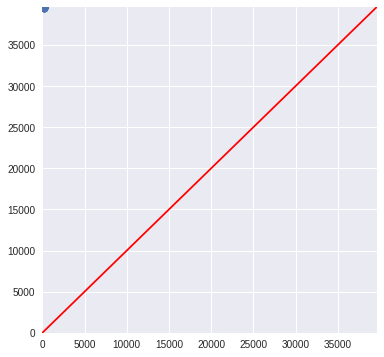

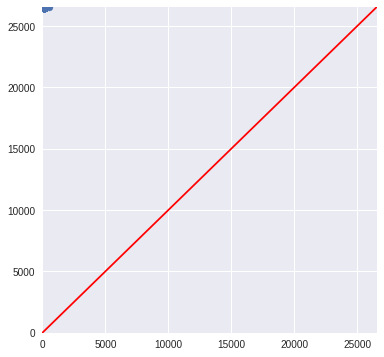

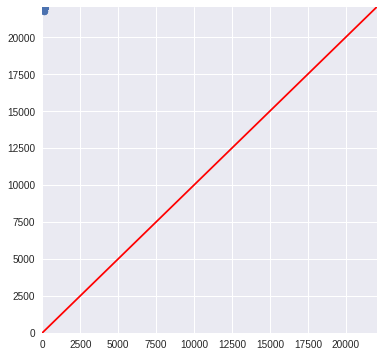

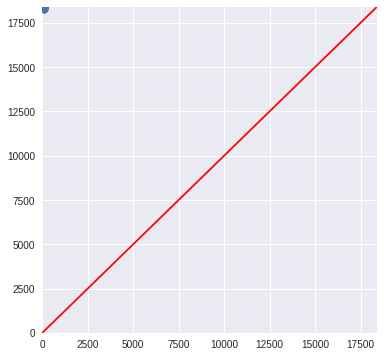

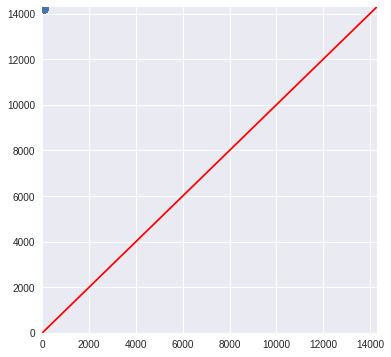

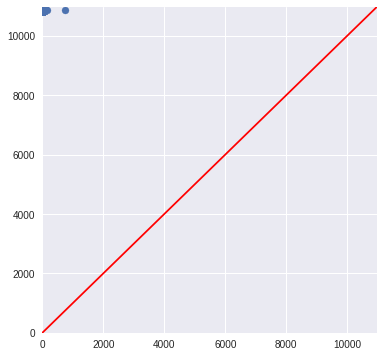

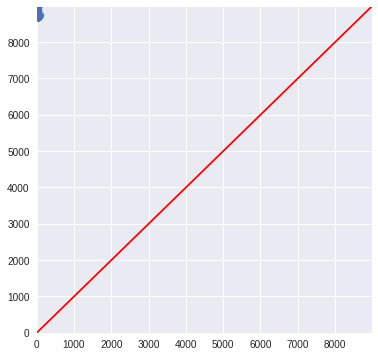

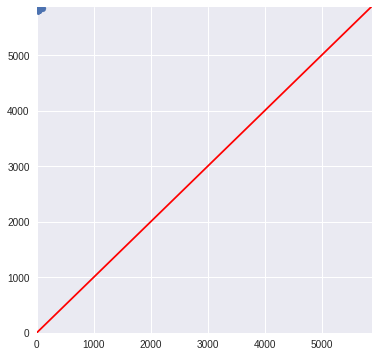

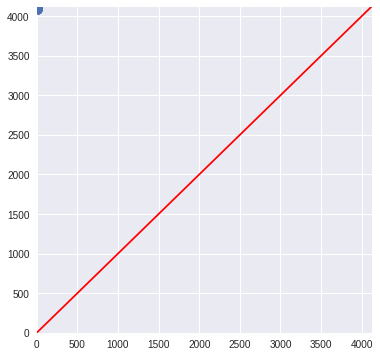

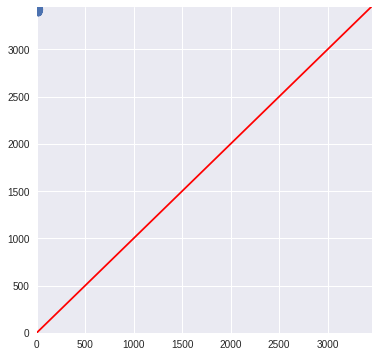

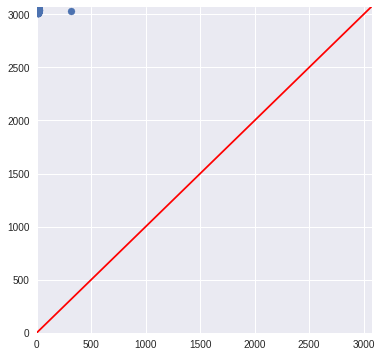

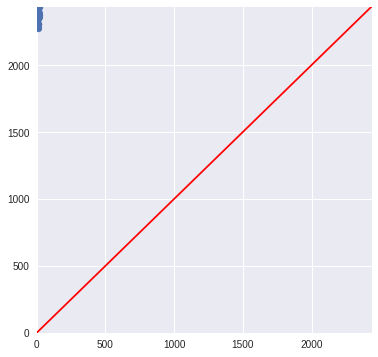

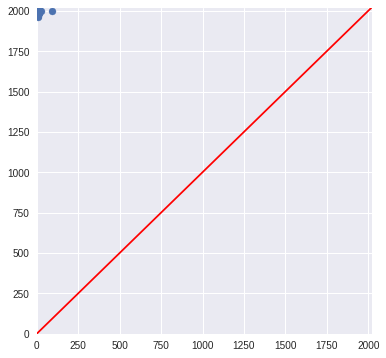

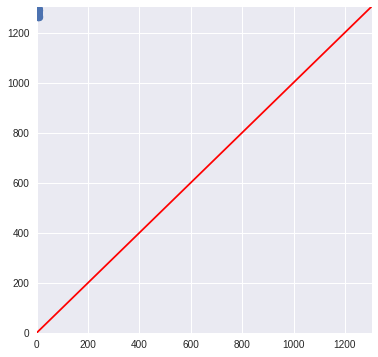

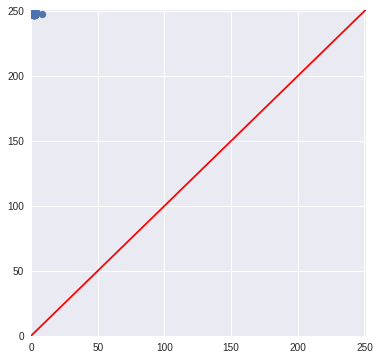

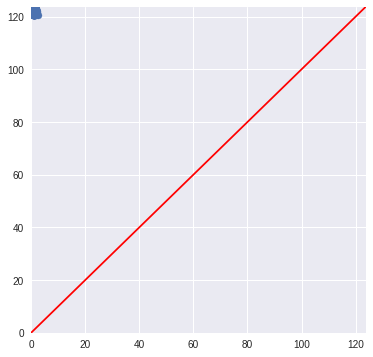

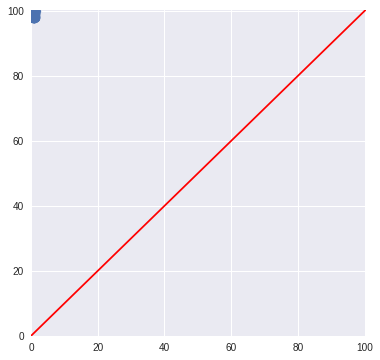

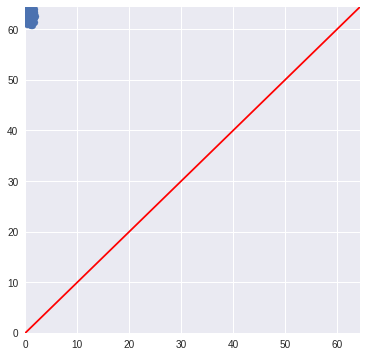

In [375]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(1,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
#    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    result = (1,4)
    m_ml, b_ml = result
#    if b_ml > 0:
    ndim, nwalkers = len(result), 100
    pos = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0),filt.sum(),x.max())
    coun+=1
    discrepq(samples,x,y,yerr)

1 [ 0.13014327  0.02456933] 8792 837.038654193
Rejection rate = 98 %
Bayesian p-value: 0.0
2 [ 0.15043434  0.02151066] 7206 837.038654193
Rejection rate = 85 %
Bayesian p-value: 0.0
3 [ 0.27756952  0.01813189] 5234 837.038654193
Rejection rate = 39 %
Bayesian p-value: 0.0
4 [ 0.37923375  0.01217702] 3843 837.038654193
Rejection rate = 15 %
Bayesian p-value: 0.0
5 [ 0.1172364  3.7078539] 3201 185.046755778
Rejection rate = 0 %
Bayesian p-value: 0.0
6 [ 0.1209095   3.60527027] 2742 174.444324283
Rejection rate = 0 %
Bayesian p-value: 0.0
7 [ 0.12520399  3.47789636] 2299 169.931786108
Rejection rate = 0 %
Bayesian p-value: 0.0
8 [ 0.1264853   3.43600496] 1827 169.931786108
Rejection rate = 0 %
Bayesian p-value: 0.0
9 [ 0.12894309  3.24300219] 1489 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
10 [ 0.1291908   3.17659175] 1263 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
11 [ 0.12302754  4.99205685] 1061 143.188488944
Rejection rate = 0 %
Bayesian p-value: 0.0
12 [ 0

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 [ 0.19157658  4.26257286] 53 65.6827536324
Rejection rate = 0 %
Bayesian p-value: 0.0
23 [ 0.28087443  0.16404701] 31 31.6677431289
Rejection rate = 0 %
Bayesian p-value: 0.0
24 [ 0.28736922  0.20610256] 22 31.6677431289
Rejection rate = 0 %
Bayesian p-value: 0.0
25 [ 0.21862089  3.52855932] 15 28.9241085243
Rejection rate = 0 %
Bayesian p-value: 0.0


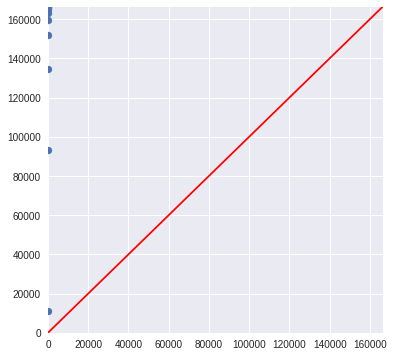

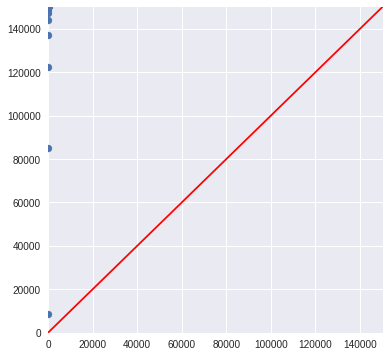

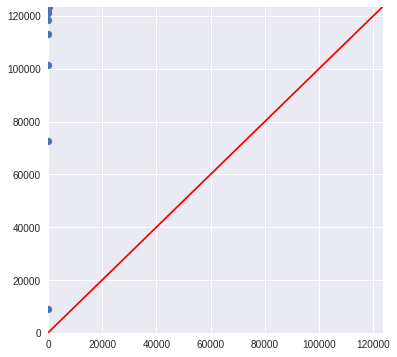

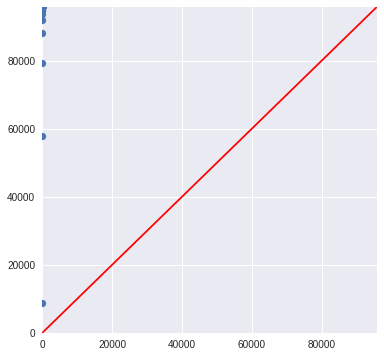

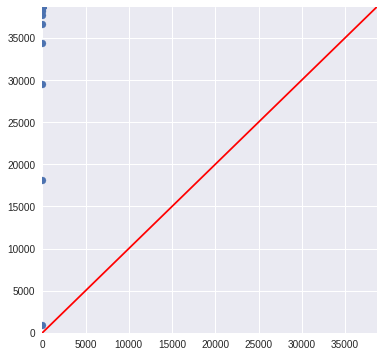

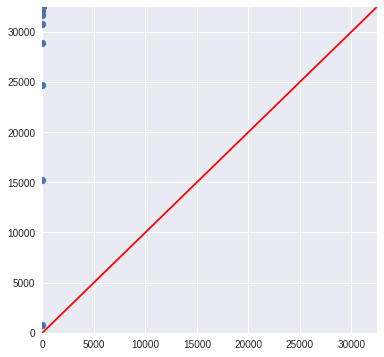

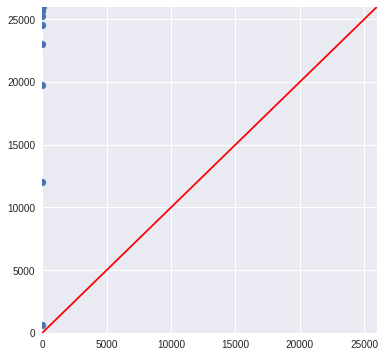

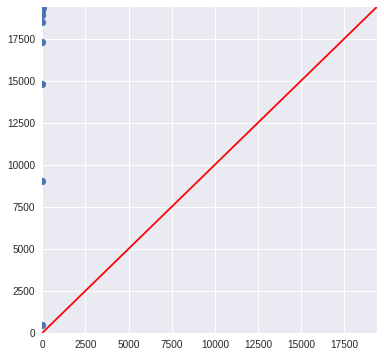

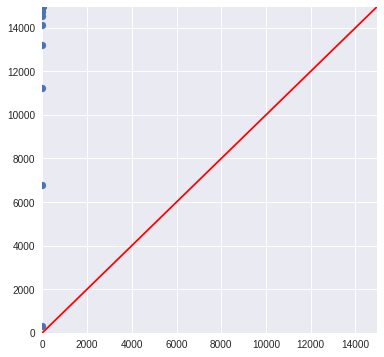

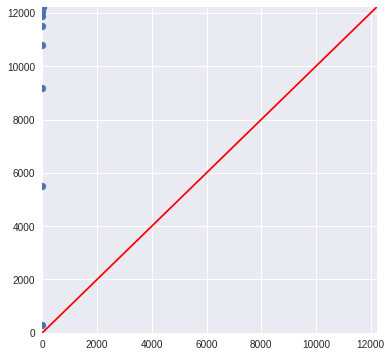

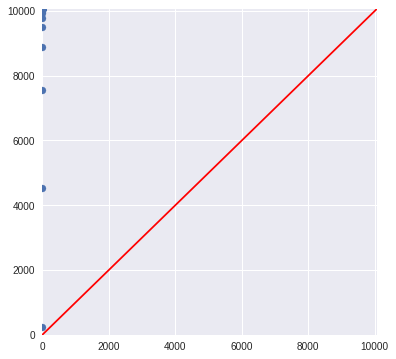

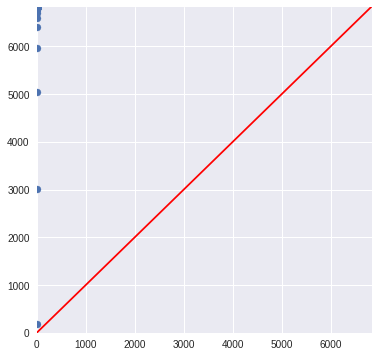

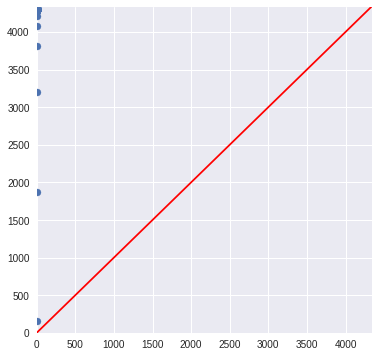

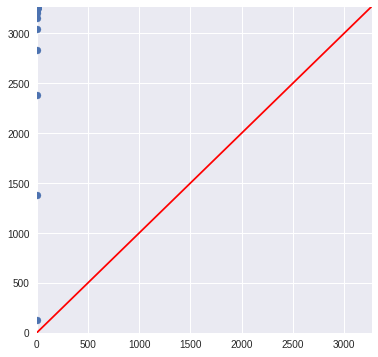

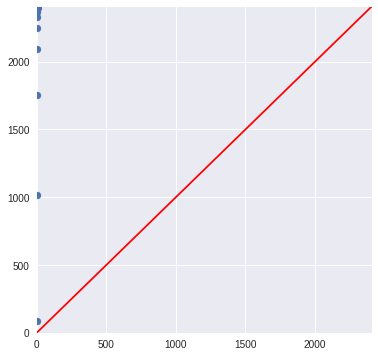

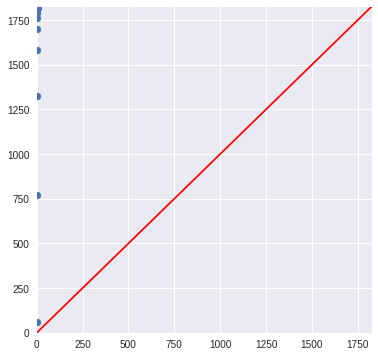

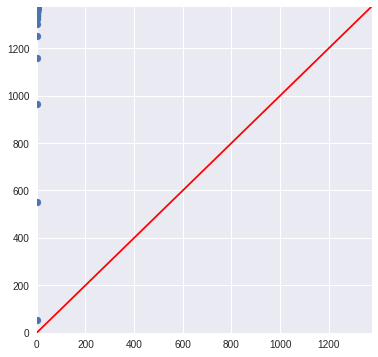

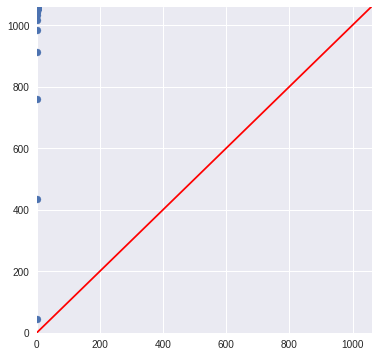

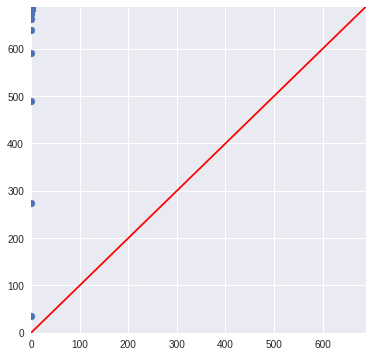

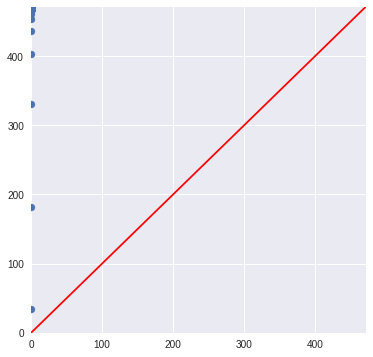

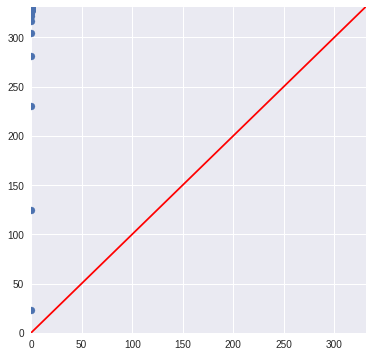

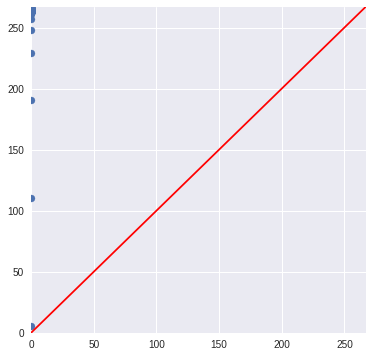

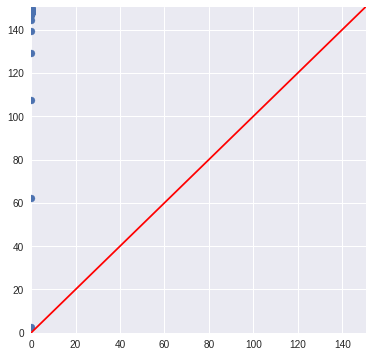

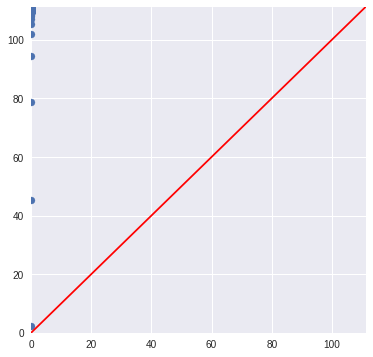

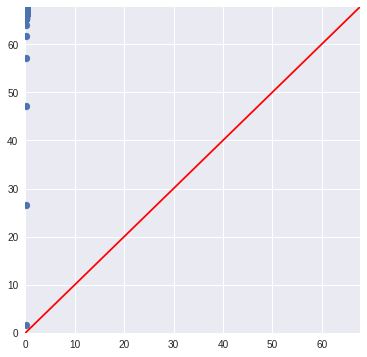

In [378]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(1,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
#    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    result = (1,4)
    m_ml, b_ml = result
#    if b_ml > 0:
    ndim, nwalkers = len(result), 100
    pos = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0),filt.sum(),x.max())
    coun+=1
    discrepq2(samples,x,y,yerr)

15 [ 0.00412615  2.38598114]
Rejection rate = 100 %
16 [ 0.00410427  2.2741868 ]
Rejection rate = 100 %
17 [ 0.00414484  2.32310752]
Rejection rate = 100 %
18 [ 0.00380702  2.41682072]
Rejection rate = 100 %
19 [ 0.00351205  2.40932232]
Rejection rate = 100 %
20 [ 0.00324021  2.40094836]
Rejection rate = 100 %
21 [ 0.0035776   2.47626619]
Rejection rate = 100 %
22 [ 0.00905003  2.07935452]
Rejection rate = 100 %
23 [ 0.01637604  1.79765069]
Rejection rate = 99 %
Bayesian p-value: 0.0
24 [ 0.01618641  1.78326413]
Rejection rate = 99 %
Bayesian p-value: 0.0
25 [ 0.01325181  1.36977426]


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Rejection rate = 98 %
Bayesian p-value: 0.0


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


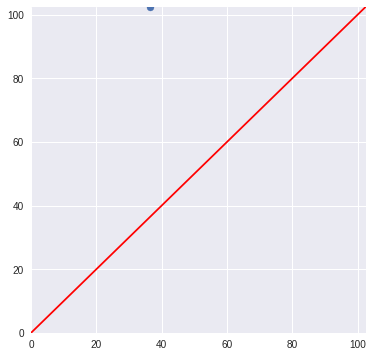

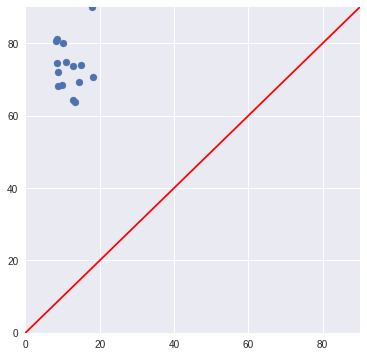

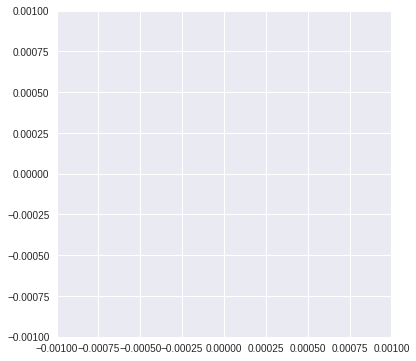

In [85]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(15,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    m_ml, b_ml = (1,4)
#    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0))
    coun+=1
    discrep1(samples,x,y,yerr)

In [77]:
samples[np.random.randint(len(samples))]

array([ 0.21950892,  3.28915728])

In [81]:
def discrep(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
            yexp=np.sqrt(yexp)
            ysim=np.sqrt(ysim)
            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

In [ ]:
plt.scatter(x,polynomial_fit(np.asarray(df_2D.iloc[0]),x)) # expected value: y_exp(theta_i)
plt.scatter(x,y) # data
plt.scatter(x,np.random.normal(polynomial_fit(np.asarray(df_2D.mean()),x),yerr)) # y_sim(theta_i)

In [111]:
def lnlike1(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior1(theta):
    m, b = theta
    if -10 < m < 10 and -50 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob1(theta, x, y,yerr):
    lp = lnprior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike1(theta, x, y,yerr)

In [112]:
def discrep1(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

26 0.317893224873 2.54061097661
26 [ 0.31427538  2.61726029]
Rejection rate = 5 %
Bayesian p-value: 0.914326007756


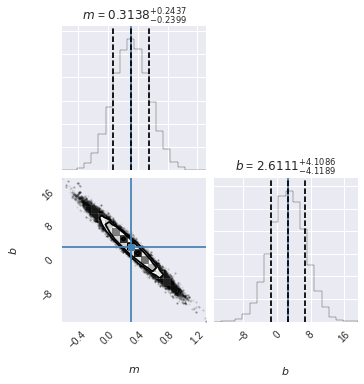

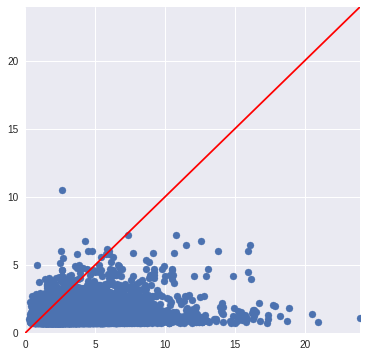

In [118]:
i=26
filt=np.array(em)>i
filt.sum()
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
nll = lambda *args: -lnlike1(*args)
result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
m_ml, b_ml = result["x"]
print(i,m_ml,b_ml)
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep1(samples,x,y,yerr)

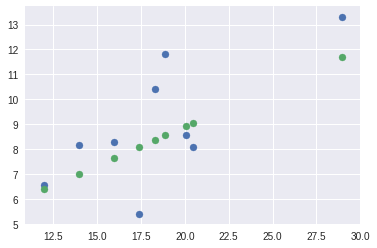

In [119]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x+sth[1])


In [181]:
def lnlike2(theta, x, y,yerr):# modelo que usa una fracción de sigma_sigma
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if -10 < m < 10 and -50 < b < 50 and 0 < f < 1.1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y,yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y,yerr)

def discrep2(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

9
26 0.356778173241 2.36943031211 0.184487983765
26 [ 0.36595324  2.24950984  0.25508761]
Rejection rate = 2 %
Bayesian p-value: 0.940239043825


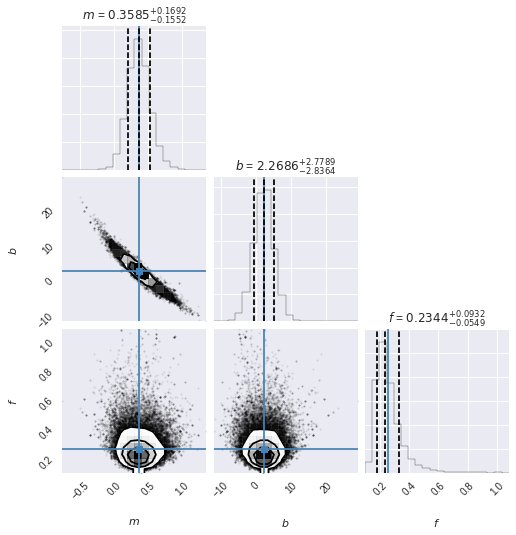

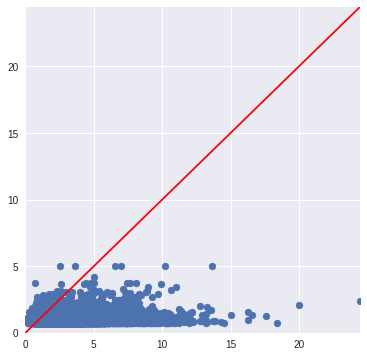

In [189]:
i=26
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
nll = lambda *args: -lnlike2(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y,yerr)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y,yerr)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep1(samples,x,y,yerr)

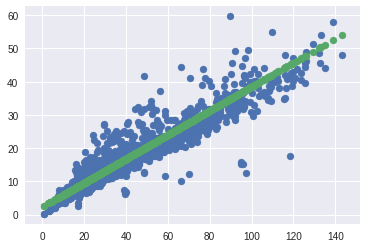

In [186]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x+sth[1])

(0, 50.0)

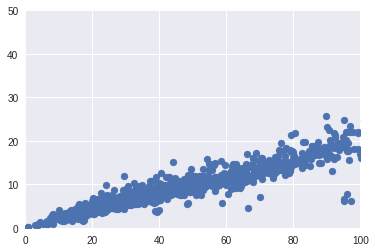

In [185]:
i=10
myx=100
filt=np.array(em)>i
filt.sum()
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
plt.scatter(x,yerr)
plt.xlim(0,myx)
plt.ylim(0,myx/2)

In [ ]:
# probar con modelo por cuadratura, -> buen diagrama de discrepancias pero no sirve para D por fuera del rango
# usarlo para el rango!!!
# cuando esta lineal sirve, pero el diagrama de discrepancias no convence

In [445]:
def lnlike3(theta, x, y,yerr):# modelo que usa una fracción de sigma_sigma
    m ,b, f = theta
    model = m * x**2+ b**2
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior3(theta):
    m, b, f = theta
    if 0 < m < 10 and 0 < b < 10 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob3(theta, x, y,yerr):
    lp = lnprior3(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike3(theta, x, y,yerr)

def discrep3(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ymod=modpar[0]*x**2+modpar[1]**2
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

53
22 0.0111420014116 2.29447196913 0.23226967916
22 [ 0.01130296  2.27878127  0.24315189]
Rejection rate = 0 %
Bayesian p-value: 0.179287305122


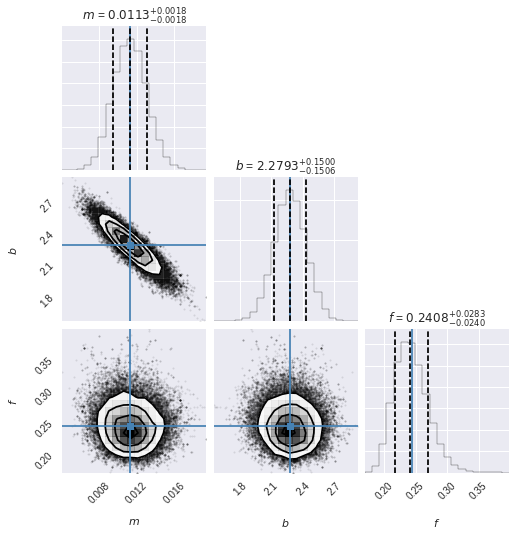

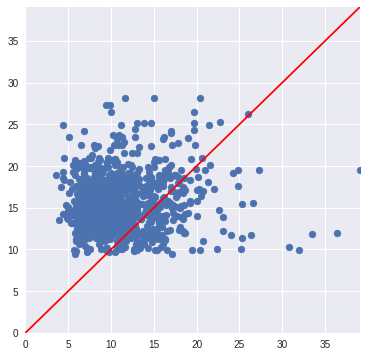

In [486]:
i=22
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#y=y**2
#yerr=yerr**2
nll = lambda *args: -lnlike3(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y,yerr)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(x, y,yerr)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep3(samples,x,y,yerr)

In [427]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,modpar[2]*(modpar[0]*x**2+modpar[1]**2))

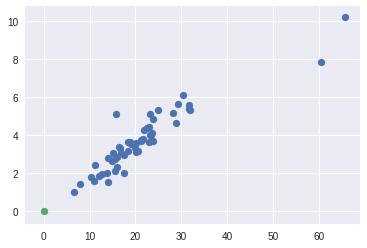

In [410]:
plt.scatter(x,yerr)
plt.scatter([0],[0])

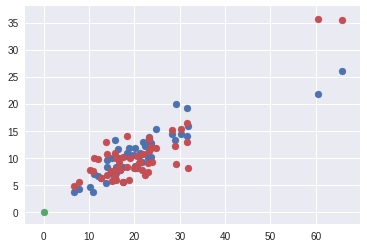

In [451]:
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

In [258]:
i=1
filt=np.array(em)>i
filt.sum()

5234

In [259]:
i=0
filt=np.array(em)>i
filt.sum()

5234

In [261]:
(np.array(em)==0).sum()

0

In [264]:
np.unique(dfs.err)

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
        0.99,  1.  ,  1.01,  1.05,  1.07,  1.09,  1.1 ,  1.11,  1.12,
        1.16,  1.17,  1.18,  1.27,  1.3 ,  1.32,  1.33,  1.38,  1.5 ,
        1.84,  6.39,  8.66])

In [292]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist2=[]
nmeas=1
for i in counter.keys():
    if counter[i]>=nmeas:
        ulist2+=[i]
dfs2=df1[np.in1d(df1['Galaxy ID'],ulist2)] # short dataframe
disterr=0.461*dfs2['D (Mpc)']*dfs2.err 
len(ulist2) ## TF measurements with reported errors

11138

In [308]:
np.unique(dfa.Method)

array(['AGB', 'AGN time lag', 'BL Lac Luminosity', 'Brightest Stars',
       'CMD', 'CO ring diameter', 'Carbon Stars', 'Cepheids', 'D-Sigma',
       'Delta Scuti', 'Diameter', 'Dwarf Ellipticals', 'Eclipsing Binary',
       'FGLR', 'FP', 'Faber-Jackson', 'G Lens', 'GC FP', 'GC K vs. (J-K)',
       'GC radius', 'GCLF', 'GRB', 'GeV TeV ratio',
       'Grav. Stability Gas. Disk', 'HII region diameter',
       'Horizontal Branch', 'LSB galaxies', 'M Stars', 'Magnetic energy',
       'Magnitude', 'Maser', 'Mass Model', 'Miras', 'Novae', 'OB Stars',
       'Orbital Mech.', 'PAGB Stars', 'PNLF', 'Proper Motion',
       'Quasar spectrum', 'RR Lyrae', 'Radio Brightness', 'Red Clump',
       'S Doradus Stars', 'SBF', 'SGRB', 'SNII optical', 'SNII radio',
       'SNIa', 'SX Phe Stars', 'SZ effect', 'Sosies', 'Statistical',
       'TRGB', 'Tertiary', 'Tully-Fisher', 'Type II Cepheids', 'Wolf-Rayet'], dtype=object)

In [333]:
dft=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
dft=dft[np.isnan(dft['redshift (z)'])]

In [334]:
dfa=dft[~np.isfinite(dft.err)] # database of non reported errors
metha=[]
ndata=[]
df1a=dfa[dfa.Method=='Tully-Fisher']
for i in np.unique(dfa.Method):
    df2a=dfa[dfa.Method==i]
    metha+=[i]
    ndata+=[df2a.shape[0]]
infoa=pd.DataFrame({'method':metha,'nrows':ndata})
infoa.sort_values(by='nrows',ascending=False).head() # non reported errors

,method,nrows
55,Tully-Fisher,8805
4,CMD,369
53,TRGB,286
3,Brightest Stars,237
40,RR Lyrae,208


In [335]:
namelista=list(df1a['Galaxy ID']) # list of galaxies
countera=collections.Counter(namelista) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist2a=[]
nmeasa=1
for i in countera.keys():
    if countera[i]>=nmeasa:
        ulist2a+=[i]
dfsa=df1a[np.in1d(df1a['Galaxy ID'],ulist2a)] # short dataframe
len(ulist2a) # TF measurements without errors (may have measurements with errors)

2970

In [346]:
ema=[]
dmeana=[]
for i in ulist2a:
    dfilter=np.in1d(dfsa['Galaxy ID'],i)
    dummy=dfsa[dfilter]
    dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb

#    names+=[i]
    ema+=[len(dummy)]

In [348]:
nulista=np.asarray(ulist2a)[~np.in1d(ulist2a,ulist2)]
measa=np.asarray(ema)[~np.in1d(ulist2a,ulist2)]
dista=np.asarray(dmeana)[~np.in1d(ulist2a,ulist2)]
len(nulista)

864

In [350]:
xlist=pd.DataFrame({'galaxy':nulista,'meas':measa,'dist':dista})
xlist.sort_values(by='meas',ascending=False).head() # non reported errors

,dist,galaxy,meas
498,22.766667,NGC 4299,6
245,15.440000,UGC 05047,5
552,19.700000,FGC 1497,5
759,84.325000,FGC 2098,4
294,83.475000,FGC 0984,4


(array([ 337.,  189.,  140.,   85.,   45.,   31.,   25.,    8.,    1.,    3.]),
 array([  7.66000000e-02,   2.70689400e+01,   5.40612800e+01,
          8.10536200e+01,   1.08045960e+02,   1.35038300e+02,
          1.62030640e+02,   1.89022980e+02,   2.16015320e+02,
          2.43007660e+02,   2.70000000e+02]),
 <a list of 10 Patch objects>)

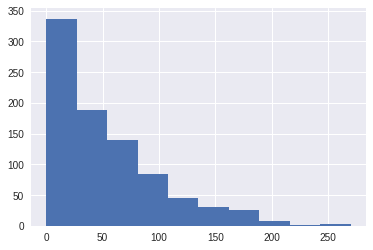

In [352]:
plt.hist(xlist.dist)

In [340]:
dft[dft['Galaxy ID']==nulista[10]]

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
1976,NaN,1566,568,FGC 0023,35.13,NaN,106.0,Tully-Fisher,2000BSAO...50....5K,NaN,NaN,NaN,NaN,20,NaN


(0, 70)

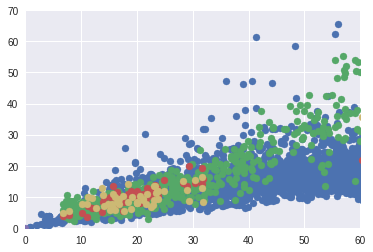

In [484]:
#funciona para el rango (modelo cuadratico)
i=2
mxlim=60
filt=np.array(em)>i
xt=np.array(dboot)[filt]
yt=np.array(bootp50)[filt]
xli=xlist.dist
xli=xli[(xli<=60)&(xli>=x.min())]
ysli=np.random.normal(modpar[0]*xli**2+modpar[1]**2,modpar[2]*(modpar[0]*xli**2+modpar[1]**2))
plt.scatter(xt,yt)
plt.scatter(xli,ysli)
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)
plt.xlim(0,mxlim)
plt.ylim(0,70)

In [464]:
((xli<=30)&(xli>=x.min())).sum()

337